## Reverse engineer a cobaya likelihood:

In [1]:
# initial imports:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

# cobaya imports:
import cobaya
print(cobaya.__path__)

# local tensiometer imports:

['/Users/marco/Software/anaconda3/lib/python3.9/site-packages/cobaya']


### Initial guess from CAMB output (useful for starting point):

In [2]:
# get a reference power spectrum using CAMB
import camb

# Set up CAMB parameters using the default values
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, As=2e-9, ns=0.965, halofit_version='mead', lmax=3000)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

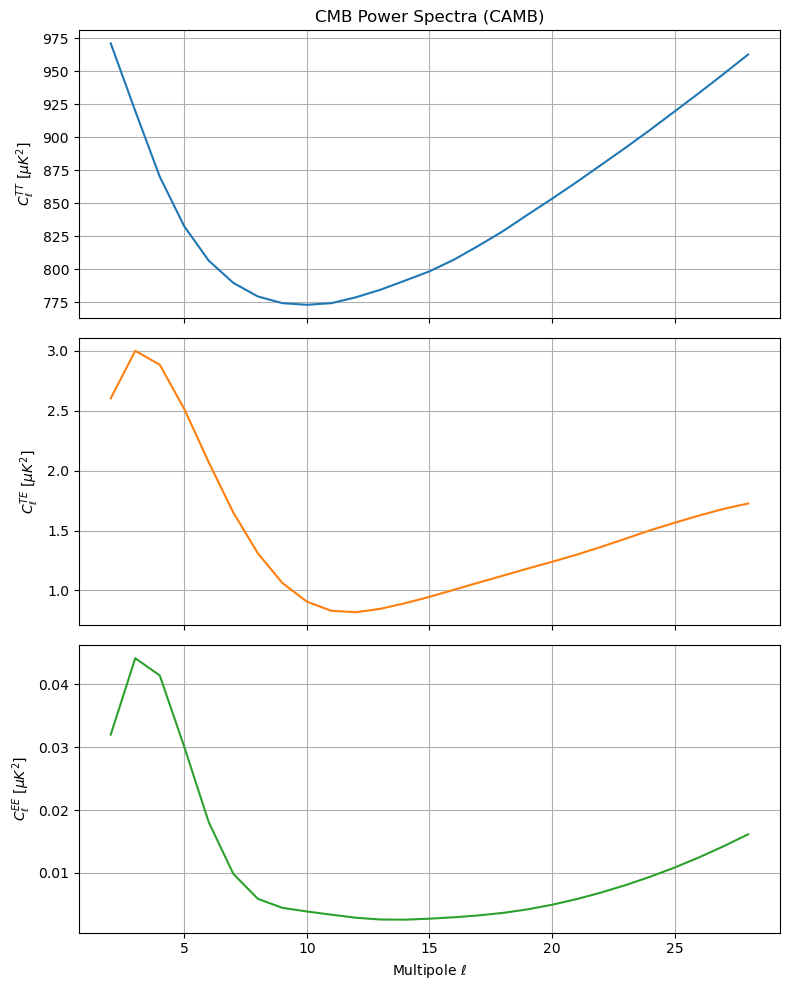

In [3]:
ell_max = 29
ells = np.arange(2, ell_max)
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# TT
axs[0].plot(ells, powers['total'][2:ell_max, 0], color='C0')
axs[0].set_ylabel(r'$C_\ell^{TT}$ [$\mu K^2$]')
axs[0].set_title('CMB Power Spectra (CAMB)')
axs[0].grid(True)

# TE
axs[1].plot(ells, powers['total'][2:ell_max, 3], color='C1')
axs[1].set_ylabel(r'$C_\ell^{TE}$ [$\mu K^2$]')
axs[1].grid(True)

# EE
axs[2].plot(ells, powers['total'][2:ell_max, 1], color='C2')
axs[2].set_ylabel(r'$C_\ell^{EE}$ [$\mu K^2$]')
axs[2].set_xlabel(r'Multipole $\ell$')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [4]:
reference_TT = powers['total'][0:29, 0]
reference_TE = powers['total'][0:29, 3]
reference_EE = powers['total'][0:29, 1]
reference_dict = {
    'ell': list(np.arange(0+1, 29+1).astype(int)),
    'tt': reference_TT,
    'te': reference_TE,
    'ee': reference_EE
}

### Build the fake model:

In [5]:
# define fake theory:
from cobaya.theory import Theory

cmb_data_extractor_params = {
    'components': ['tt', 'te', 'ee'],
    'ell_mins': [2, 2, 2],
    'ell_maxes': [29, 29, 29],
    'tt_range': [0, 1000],
    'te_range': [-10, 10],
    'ee_range': [0, 0.1],
    }

cmb_data_extractor_params_tt = {
    'components': ['tt'],
    'ell_mins': [2],
    'ell_maxes': [29],
    'tt_range': [0, 1000],
    'te_range': [-10, 10],
    'ee_range': [0, 0.1],
    }

def params_for_cmb_data_extractor(params, reference=None):
    params_priors = {}
    for _c in params['components']:
        for i in range(params['ell_mins'][params['components'].index(_c)]):
            params_priors[f'Cl{_c.upper()}_{i}'] = {
                'value': 0.0,
            }
        for i in range(params['ell_mins'][params['components'].index(_c)],
                       params['ell_maxes'][params['components'].index(_c)] + 1):
            _min = params[f'{_c}_range'][0]
            _max = params[f'{_c}_range'][1]
            if reference is not None:
                _idx = reference['ell'].index(i)
                _proposal = np.std(reference[_c])
                _center = reference[_c][_idx]
            else:
                _proposal = (_max - _min) / 100.0
                _center = (_max + _min) / 2.0
            params_priors[f'Cl{_c.upper()}_{i}'] = {
                'prior': {'min': _min, 'max': _max},
                'proposal': _proposal,
                'ref': _center,
            }
    return params_priors

class CMBDataExtractor(Theory):

    def initialize(self):
        """called from __init__ to initialize"""
        self.params = {}

    def initialize_with_provider(self, provider):
        """
        Initialization after other components initialized, using Provider class
        instance which is used to return any dependencies (see calculate below).
        """
        self.provider = provider

    def get_can_provide(self):
        return ['Cl']
    
    def get_requirements(self):
        _requirements = []
        for _c in self.components:
            for i in range(self.ell_mins[self.components.index(_c)]):
                _requirements.append(f'Cl{_c.upper()}_{i}')
            for i in range(self.ell_mins[self.components.index(_c)],
                            self.ell_maxes[self.components.index(_c)] + 1):
                 _requirements.append(f'Cl{_c.upper()}_{i}')
        return _requirements

    def must_provide(self, **requirements):
        if 'Cl' in requirements:
            if not hasattr(self, 'components'):
                raise ValueError("CMBDataExtractor must provide 'components' attribute")
            if 'tt' in requirements['Cl'] and not 'tt' in self.components:
                raise ValueError("CMBDataExtractor must provide 'tt' component")
            if 'te' in requirements['Cl'] and not 'te' in self.components:
                raise ValueError("CMBDataExtractor must provide 'te' component")
            if 'ee' in requirements['Cl'] and not 'ee' in self.components:
                raise ValueError("CMBDataExtractor must provide 'ee' component")
    
    def calculate(self, state, want_derived=True, **params_values_dict):
        state['Cl'] = {}
        for _c in self.components:
            state['Cl'][_c] = []
            for i in range(self.ell_mins[self.components.index(_c)]):
                state['Cl'][_c].append(params_values_dict[f'Cl{_c.upper()}_{i}'])
            for i in range(self.ell_mins[self.components.index(_c)],
                           self.ell_maxes[self.components.index(_c)] + 1):
                state['Cl'][_c].append(params_values_dict[f'Cl{_c.upper()}_{i}'])
            state['Cl'][_c] = np.array(state['Cl'][_c])
                
    def get_Cl(self, ell_factor=False):
        return self.current_state['Cl']

### CMB TT:

In [6]:
# define parameters (in this case the BAO)
params = {
    "debug": False,
    "theory": {'CMBDataExtractor': CMBDataExtractor(cmb_data_extractor_params_tt)},
    "likelihood": {"planck_2018_lowl.TT": None},
    "params": params_for_cmb_data_extractor(cmb_data_extractor_params_tt),
    "sampler": {"mcmc": None}
}


In [7]:
# rebuild the model:
from cobaya.model import get_model
# build the model:
model = get_model(params)

[input] *WARNING* Support for input instances is experimental
[model] *WARNING* Ignored blocks/options: ['sampler']


In [8]:
from cobaya.run import run

updated_info, sampler = run(params)

[input] *WARNING* Support for input instances is experimental
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: ClTT_2:500, ClTT_3:500, ClTT_4:500, ClTT_5:500, ClTT_6:500, ClTT_7:500, ClTT_8:500, ClTT_9:500, ClTT_10:500, ClTT_11:500, ClTT_12:500, ClTT_13:500, ClTT_14:500, ClTT_15:500, ClTT_16:500, ClTT_17:500, ClTT_18:500, ClTT_19:500, ClTT_20:500, ClTT_21:500, ClTT_22:500, ClTT_23:500, ClTT_24:500, ClTT_25:500, ClTT_26:500, ClTT_27:500, ClTT_28:500, ClTT_29:500
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {planck_2018_lowl.TT: 46200.0, CMBDataExtractor: 34500.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-06-20 16:03:47 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 1120 samples accepted.
[mcmc]  - Acceptance rate: 0.856
[mcmc]  - Converg

In [9]:
# getdist samples:
gd_sample = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

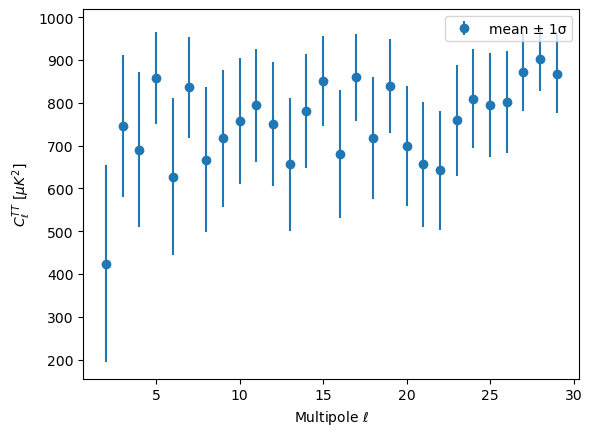

In [10]:
# Extract means and standard deviations from the covariance matrix
means = gd_sample.means[0:28]
stds = np.sqrt(np.diag(gd_sample.fullcov))[0:28]

plt.errorbar(range(2, 30), means, yerr=stds, fmt='o', label='mean ± 1σ')
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell^{TT}$ [$\mu K^2$]')
plt.legend()
plt.show()